<a href="https://colab.research.google.com/github/ppfenninger/Sensorimotor_Learning_Final/blob/main/Final_DoorKeyEnv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spring 2023 6.8200 Computational Sensorimotor Learning Assignment 2

In this assignment, we will implement model-free RL algorithms from scratch to solve `DoorKeyEnv5x5`.  We will cover:


* REINFORCE
* Vanilla Policy Gradient (VPG)
* Generalized Advantage Estimation (GAE)
* Proximal Policy Optimization (PPO)

You will need to **answer the bolded questions** and **fill in the missing code snippets** (marked by **TODO**).

There are (approximately) **150** total points to be had in this PSET.  `ctrl-f` for "pts" to ensure you don't miss questions.

**_Please fill in your name below:_**

**Name**: Matthew Robins

## Setup

The following code sets up requirements, imports, and helper functions (you can ignore this).

In [ ]:
!pip3 install -i https://test.pypi.org/simple/ sensorimotor-checker==0.0.8  &>/dev/null

In [ ]:
!pip install gym-minigrid &>/dev/null

In [ ]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import torch.nn.functional as F
import gym_minigrid
import numpy as np
import matplotlib.pyplot as plt
import gym
from tqdm.notebook import tqdm
from gym_minigrid.envs.doorkey import DoorKeyEnv
import pandas as pd
import random
from sensorimotor_checker import hw2_tests

#### Added imports
from google.colab import files, drive
import pickle

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:307: DeprecationWarning: The package name gym_minigrid has been deprecated in favor of minigrid. Please uninstall gym_minigrid and install minigrid with `pip install minigrid`. Future releases will be maintained under the new package name minigrid.
  fn()


In [ ]:
checker_policy_gradient = hw2_tests.TestPolicyGradients()     

In [ ]:
# Function from https://github.com/ikostrikov/pytorch-a2c-ppo-acktr/blob/master/model.py
def init_params(m):
    classname = m.__class__.__name__
    if classname.find("Linear") != -1:
        m.weight.data.normal_(0, 1)
        m.weight.data *= 1 / torch.sqrt(m.weight.data.pow(2).sum(1, keepdim=True))
        if m.bias is not None:
            m.bias.data.fill_(0)

def preprocess_obss(obss, device=None):
    if isinstance(obss, dict):
        images = np.array([obss["image"]])
    else:
        images = np.array([o["image"] for o in obss])
    
    return torch.tensor(images, device=device, dtype=torch.float)

#### changed
class SizedDoorKeyEnv(DoorKeyEnv):
    def __init__(self, size=5):
        super().__init__(size=size)
    
    def _reward(self):
        """
        Compute the reward to be given upon success
        """
        return 1

## Config

In [ ]:
class Config:
    def __init__(self,
                score_threshold=0.93,
                discount=0.995,
                lr=1e-3,
                max_grad_norm=0.5, 
                log_interval=10,
                max_episodes=2000,
                bernoulli_param=0.5,
                gae_lambda=0.95,
                num_critics=0,
                clip_ratio=0.2,
                target_kl=0.01,
                train_ac_iters=5,
                use_discounted_reward=False,
                exploration_beta = 0.1,
                entropy_coef=0.01,
                use_gae=False,
                exploration_update_freq = 10,
                tau = .95,
                use_soft_target_update = False, 
                seed=0, ####added
                env_size=5, ####added
                critic_mask_for_ep=False #### added 
                  ):
        
        self.score_threshold = score_threshold
        self.discount = discount
        self.lr = lr
        self.max_grad_norm = max_grad_norm
        self.log_interval = log_interval
        self.bernoulli_param = bernoulli_param
        self.max_episodes = max_episodes
        self.num_critics = num_critics
        self.clip_ratio = clip_ratio
        self.target_kl = target_kl
        self.train_ac_iters = train_ac_iters
        self.gae_lambda=gae_lambda
        self.use_discounted_reward=use_discounted_reward
        self.exploration_beta = exploration_beta
        self.entropy_coef = entropy_coef
        self.use_gae = use_gae
        self.exploration_update_freq = exploration_update_freq
        self.tau = tau
        self.use_soft_target_update = use_soft_target_update
        self.seed=seed
        self.env_size=env_size
        self.critic_mask_for_ep = critic_mask_for_ep

# Task (Environment)

In this assignment, we will work with the `DoorKeyEnv5x5` environment from [gym_miniworld](https://github.com/maximecb/gym-minigrid). This environment is a $5\times 5$ gridworld. The agent needs to pick up the key, open the door, and then go the the green cell. The agent gets a $+1$ reward if it reaches the green cell, and a $0$ reward otherwise.

The environment is visually shown below:

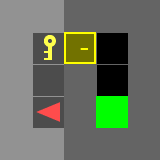

In [ ]:
env = SizedDoorKeyEnv(5)
from gym.utils import seeding
env._np_random, seed = seeding.np_random(0)

**Question**: What does `env.reset()` return? What does each item returned mean? What's the shape of the image in the observation? How about the action space? What does each action mean? (Hint: You may find the source code of gym_minigrid helpful.) (10 pts)

**Answer**: It returns a tuple whose first element is a dictionary with keys: 'image', 'direction', and 'mission'. The 'image' is a representation of the door key environment. The 'direction' indicates which direction the agent is orginally facing. The mission is a text indication of what the agent's goal is; in this case it is "use the key to open the door and then get to the goal." The shape of the image observation is a 7 by 7 by 3. Each tile in the image is 3 element tuple of (OBJECT_IDX, COLOR_IDX, STATE). The action space contains 7 actions corresponding to integers 0-6. Actions 0, 1, and 2 are turn left, turn right, and move forward respectively. Action 3 picks up an object. Action 4, denoted "drop" is actually unused. Action 5 is to toggle/activate an object. Action 6, denoted "done" is also unused.

# Model

In Deep Q-Learning, we estimated the value function for each (state, action) pair. In policy gradients, we will directly learn a policy: i.e, for each state, predict an action!  We call this policy network the *actor*.

Our *actor* will take in as input the `DoorKeyEnv5x5` observation (a 7x7x3 image), and output a categorical distribution over all possible actions.  To choose an action, we will sample from this distribution.  We suggest implementing the actor network to contain a few convolutional layers, followed by a few fully-connected layers.

In addition to the actor network, later questions in the PSET require estimating the value network, called the *critic*.  The critic estimates total future reward, much like DQN in PSET 3, but is notably *on-policy*, meaning it's reward estimates are conditioned on the actor. We will use the critic to reduce variance in the policy gradient estimate. We will get to that soon. 

We have provided you a reference architecture to use for your actor-critic networks. Note that we have separate networks for each that do not share weights, as this has been shown to empirically improve performance. Also note that the policy outputs a `torch.distributions.categorical.Categorical` object.

## without shared architecture

In [ ]:
         # self.image_conv_critics = nn.ModuleList([nn.Sequential(
          #       nn.Conv2d(3, 16, (2, 2)),
          #       nn.ReLU(),
          #       nn.MaxPool2d((2, 2)),
          #       nn.Conv2d(16, 32, (2, 2)),
          #       nn.ReLU(),
          #       nn.Conv2d(32, 64, (2, 2)),
          #       nn.ReLU()
          #   )] * self.num_critics)

          # self.critics = nn.ModuleList([nn.Sequential(
          #       nn.Linear(64, 64),
          #       nn.Tanh(),
          #       nn.Linear(64, 1)
          #   )] * self.num_critics)

In [ ]:
# class ACModel(nn.Module):
#     def __init__(self, num_actions, num_critics=0):
#         super().__init__()
#         self.num_critics = num_critics

#         # Define actor's model
#         self.image_conv_actor = nn.Sequential(
#             nn.Conv2d(3, 16, (2, 2)),
#             nn.ReLU(),
#             nn.MaxPool2d((2, 2)),
#             nn.Conv2d(16, 32, (2, 2)),
#             nn.ReLU(),
#             nn.Conv2d(32, 64, (2, 2)),
#             nn.ReLU()
#         )
#         self.actor = nn.Sequential(
#             nn.Linear(64, 64),
#             nn.Tanh(),
#             nn.Linear(64, num_actions)
#         )

#         # Define critic's model
#         if self.num_critics > 0:
          
#           self.image_conv_critics = nn.ModuleList([nn.Sequential(
#               nn.Conv2d(3, 16, (2, 2)),
#               nn.ReLU(),
#               nn.MaxPool2d((2, 2)),
#               nn.Conv2d(16, 32, (2, 2)),
#               nn.ReLU(),
#               nn.Conv2d(32, 64, (2, 2)),
#               nn.ReLU()
#           ) for _ in range(self.num_critics)])

#           self.critics = nn.ModuleList([nn.Sequential(
#               nn.Linear(64, 64),
#               nn.Tanh(),
#               nn.Linear(64, 1)
#           ) for _ in range(self.num_critics)])
            

#         # Initialize parameters correctly
#         self.apply(init_params)

#     def forward(self, obs):
#       conv_in = obs.transpose(1, 3).transpose(2, 3) # reshape into expected order

#       dist, value, std_dev = None, None, None


#       x = self.image_conv_actor(conv_in)
#       embedding = x.reshape(x.shape[0], -1)

#       x = self.actor(embedding)

#       dist = Categorical(logits=F.log_softmax(x, dim=1))
#       if self.num_critics > 1:
#           # Choose a random subset of critics based on the bernoulli_param
#           critics_mask = torch.tensor([1 if random.random() <= args.bernoulli_param else 0 for _ in range(self.num_critics)], device=x.device, dtype=torch.float)
#           # Ensure that at least one critic is used
#           if torch.sum(critics_mask) == 0:
#               selected_critic = random.choice(range(self.num_critics))
#               critics_mask[selected_critic] = 1


#           ys = [image_conv_critic(conv_in) for image_conv_critic in self.image_conv_critics]
#           embeddings = [y.reshape(y.shape[0], -1) for y in ys]

#           # values = torch.stack([critic(embedding).squeeze(1) for critic, embedding in zip(self.critics, embeddings)]).to(x.device)
#           # masked_values = values * critics_mask[:, None]
#           # value = torch.sum(masked_values, dim=0) / torch.sum(critics_mask)

#           values = torch.stack([critic(embedding).squeeze(1) for critic, embedding in zip(self.critics, embeddings)]).to(x.device)

#           # Get indices where critics_mask is true (1)
#           selected_critics_indices = torch.nonzero(critics_mask, as_tuple=True)[0]

#           # Index the values based on selected_critics_indices
#           selected_values = values[selected_critics_indices]

#           # Compute the mean value
#           value = torch.mean(selected_values, dim=0)

#           # Calculate standard deviation over all critics, not just selected ones
#           std_dev = torch.std(values, dim=0)

#       elif self.num_critics ==1 :
#           y = self.image_conv_critics[0](conv_in)
#           embedding = y.reshape(y.shape[0], -1)

#           value = self.critics[0](embedding).squeeze(1)
#           std_dev = 0
#       else:
#           value = torch.zeros((x.shape[0], 1), device=x.device)
#           std_dev = 0
#       return dist, value, std_dev

## With shared architecture

In [ ]:
class ACModel(nn.Module): #### ADDED ARGS
    def __init__(self, num_actions, args, num_critics=0):
        super().__init__()
        self.num_critics = num_critics
        self.args = args
        self.critic_mask = None

        # Define actor's model
        self.image_conv_actor = nn.Sequential(
            nn.Conv2d(3, 16, (2, 2)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(16, 32, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(32, 64, (2, 2)),
            nn.ReLU()
        )
        self.actor = nn.Sequential(
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, num_actions)
        )

        self.shared_image_conv = nn.Sequential(
            nn.Conv2d(3, 16, (2, 2)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(16, 32, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(32, 64, (2, 2)),
            nn.ReLU()
        )

        self.shared_critic_layers = nn.Sequential(
            nn.Linear(64, 64),
            nn.Tanh()
        )

        # Define critic's model
        if self.num_critics > 0:
          self.critics = nn.ModuleList([nn.Linear(64, 1) for _ in range(self.num_critics)])
            

        # Initialize parameters correctly
        self.apply(init_params)

    def set_critic_mask(self, critic_mask): 
        self.critic_mask = critic_mask

    def forward(self, obs):
        conv_in = obs.transpose(1, 3).transpose(2, 3)  # reshape into expected order

        dist, value, std_dev = None, None, None

        x = self.image_conv_actor(conv_in)
        embedding = x.reshape(x.shape[0], -1)

        x = self.actor(embedding)

        dist = Categorical(logits=F.log_softmax(x, dim=1))

        if self.num_critics > 1:
          if self.critic_mask is not None:
            critics_mask =  self.critic_mask
            
          else: # not passing in a critic mask
            # Choose a random subset of critics based on the bernoulli_param
            critics_mask = torch.tensor([1 if random.random() <= self.args.bernoulli_param else 0 for _ in range(self.num_critics)], device=x.device, dtype=torch.float)
            
            # Ensure that at least one critic is used
            if torch.sum(critics_mask) == 0:
                selected_critic = random.choice(range(self.num_critics))
                critics_mask[selected_critic] = 1

          y = self.shared_image_conv(conv_in)
          embedding = y.reshape(y.shape[0], -1)

          shared_output = self.shared_critic_layers(embedding)

          values = torch.stack([critic(shared_output).squeeze(1) for critic in self.critics]).to(x.device)

          # Get indices where critics_mask is true (1)
          selected_critics_indices = torch.nonzero(critics_mask, as_tuple=True)[0]

          # Index the values based on selected_critics_indices
          selected_values = values[selected_critics_indices]

          # Compute the mean value
          value = torch.mean(selected_values, dim=0)

          # Calculate standard deviation over all critics, not just selected ones
          std_dev = torch.std(values, dim=0)
          # print("critic_mask inside forward", critics_mask)

        elif self.num_critics ==1 :
          y = self.shared_image_conv(conv_in)
          embedding = y.reshape(y.shape[0], -1)

          value = self.critics[0](self.shared_critic_layers(embedding).squeeze(1)).squeeze(1)
          std_dev = 0

        else:
            value = torch.zeros((x.shape[0], 1), device=x.device)
            std_dev = 0

        return dist, value, std_dev

# Computing gae and returns 

The following code runs the actor critic model `acmodel` for one episode, and returns a dictionary with all the relevant information from the rollout.  It relies on placeholders below for `compute_advantage_gae` and `compute_discounted_return`: you can ignore these for now, and just evaluate through to the next section.  However, it might be useful to review this code just to make sure you understand what's going on.

In [ ]:
def compute_advantage_gae(values, rewards, T, gae_lambda, discount):
    advantages = torch.zeros_like(values)
    
    # Recursively calculate advantages
    for t in reversed(range(len(rewards)-1)):
      delta = - values[t] + rewards[t] + discount * values[t+1] 
      advantages[t] = delta + (discount * gae_lambda) * advantages[t+1]
    ############################################################################
    
    return advantages[:T]

#### Test GAE ####
checker_policy_gradient.test_general_advantage_estimation(compute_advantage_gae)

In [ ]:
def compute_discounted_return(rewards, discount, device=None):
    returns = torch.zeros(*rewards.shape, device=device)

    #### TODO: populate discounted reward trajectory (10 pts) ############
    discounts = discount**torch.arange(len(rewards), device=device)
    returns = discounts * rewards
    returns = torch.flip(torch.cumsum(torch.flip(returns, dims=(0,)), dim=0), dims=(0,))
    ######################################################################

    return returns
    
#### Test discounted return ####
checker_policy_gradient.test_compute_discounted_return(compute_discounted_return)

# Collect experiences

In [ ]:
def collect_experiences(env, acmodel, args, device=None, target_acmodel=None, total_steps=None, critic_mask=None):
    """Collects rollouts and computes advantages.
    Returns
    -------
    exps : dict
        Contains actions, rewards, advantages etc as attributes.
        Each attribute, e.g. `exps['reward']` has a shape
        (self.num_frames, ...).
    logs : dict
        Useful stats about the training process, including the average
        reward, policy loss, value loss, etc.
    """


    MAX_FRAMES_PER_EP = 300
    shape = (MAX_FRAMES_PER_EP, )

    actions = torch.zeros(*shape, device=device, dtype=torch.int)
    values = torch.zeros(*shape, device=device)
    std_devs = torch.zeros(*shape, device=device)
    rewards = torch.zeros(*shape, device=device)
    exploration_bonuses = torch.zeros(*shape, device=device)
    rewards_with_bonus = torch.zeros(*shape, device=device) 
    log_probs = torch.zeros(*shape, device=device)
    obss = [None]*MAX_FRAMES_PER_EP

    obs, _ = env.reset()

    total_return = 0

    T = 0

    ## change: 
    if critic_mask is not None: 
      # target critic always uses all the critics for std 
      target_critic_mask = torch.ones(args.num_critics, device=device)
      target_acmodel.set_critic_mask(target_critic_mask)
      # training criti uses the same mask per episode 
      acmodel.set_critic_mask(critic_mask)
      # print("ac_model critic mask in collect_experiences", acmodel.critic_mask)
    else: 
      pass
      # print("critic mask is None")

    while True:
        # Do one agent-environment interaction

        preprocessed_obs = preprocess_obss(obs, device=device)

        if total_steps:  
          if total_steps % args.exploration_update_freq == 0: 
            update_target_vnet(acmodel, target_acmodel, args=args)

        
        with torch.no_grad():
          
          dist, value, std_dev = acmodel(preprocessed_obs)

          if target_acmodel: # we want to use target std instead
            _ , _ , std_dev = target_acmodel(preprocessed_obs)
        
        action = dist.sample()[0]

        obss[T] = obs
        obs, reward, done, _, _ = env.step(action.item())


        # Update experiences values
        actions[T] = action
        values[T] = value
        std_devs[T] = std_dev
        exploration_bonuses[T] = args.exploration_beta * std_dev
        rewards[T] = reward
        rewards_with_bonus[T] = reward + exploration_bonuses[T]


        log_probs[T] = dist.log_prob(action)


        total_return += reward
        T += 1

        if done or T>=MAX_FRAMES_PER_EP:
            break

    discounted_reward = compute_discounted_return(rewards[:T], args.discount, device)
    discounted_reward_with_bonus = compute_discounted_return(rewards_with_bonus[:T], args.discount, device)

    exps = dict(
        obs = preprocess_obss([
            obss[i]
            for i in range(T)
        ], device=device),
        action = actions[:T],
        value  = values[:T],
        std_dev = std_devs[:T],
        reward = rewards[:T],
        advantage = discounted_reward-values[:T],
        advantage_with_bonus = discounted_reward_with_bonus-values[:T],
        log_prob = log_probs[:T],
        discounted_reward = discounted_reward,
        discounted_reward_with_bonus = discounted_reward_with_bonus,
        exploration_bonuses = exploration_bonuses,
        advantage_gae=compute_advantage_gae(values, rewards, T, args.gae_lambda, args.discount),
        advantage_gae_with_bonus = compute_advantage_gae(values, rewards_with_bonus, T, args.gae_lambda, args.discount)
    )

    logs = {
        "return_per_episode": total_return,
        "num_frames": T
    }

    return exps, logs

def update_target_vnet(acmodel, target_acmodel, args): #### CHANGED
    if not args.use_soft_target_update:
        #### TODO: update the target Q function in a "hard" way
        #### copy the parameter values in self.qnet into self.target_qnet
        target_acmodel.load_state_dict(acmodel.state_dict())

    else:
        #### TODO: soft update on taget Q network.
        #### similar to polyak averaging, we update the target Q network slowly
        #### $\theta_Qtgt = \tau*\theta_Qtgt + (1-\tau)*\theta_Q
        for param, new_param in zip(target_acmodel.parameters(), acmodel.parameters()) :
              #  param.data =  self.tau*param.data + (1.0-self.tau)*new_param.data
              param.data.copy_(args.tau * param.data + (1.0 - args.tau)*new_param.data) #### CHANGED

# Implementation 

Now, let's try to run our implementation.  The following experiment harness is written for you, and will run sequential episodes of policy gradients until `args.max_episodes` timesteps are exceeded or the rolling average reward (over the last 100 episodes is greater than `args.score_threshold`. It is expected to get highly variable results, and we'll visualize some of this variability at the end.

The method accepts as arguments a `Config` object `args`, and a `parameter_update` method (such as `update_parameters_reinforce`).

In [ ]:
#KEYS

'''obs action value std_dev 
reward advantage advantage_with_bonus
log_prob discounted_reward discounted_reward_with_bonus
exploration_bonuses advantage_gae advantage_gae_with_bonus'''

def calculate_logging_stats(exps):
  logs = dict(
      avg_std_dev = torch.mean(exps['std_dev']).item()
  )
  return logs


In [40]:
def run_experiment(args, parameter_update, seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    env = SizedDoorKeyEnv(args.env_size) ####CHANGED LINE

    acmodel = ACModel(env.action_space.n, num_critics=args.num_critics, args=args) #### CHANGED
    target_acmodel = ACModel(env.action_space.n, args=args, num_critics=args.num_critics) #### CHANGE
    # acmodel.move_to_device(device)
    acmodel.to(device)
    target_acmodel.to(device)

    is_solved = False
    
    SMOOTH_REWARD_WINDOW = 50

    pd_logs, rewards = [], [0]*SMOOTH_REWARD_WINDOW
    
    optimizer = torch.optim.Adam(acmodel.parameters(), lr=args.lr)
    num_frames = 0
    num_eps = 0

    pbar = tqdm(range(args.max_episodes))
    for update in pbar:
        critics_mask = None
        if args.critic_mask_for_ep: 
          critics_mask = torch.tensor([1 if random.random() <= args.bernoulli_param else 0 for _ in range(args.num_critics)], device=device, dtype=torch.float)
          if torch.sum(critics_mask) == 0:
                selected_critic = random.choice(range(args.num_critics))
                critics_mask[selected_critic] = 1

        exps, logs1 = collect_experiences(env, acmodel, args, device, target_acmodel=target_acmodel, total_steps=num_frames, critic_mask=critics_mask)
        logs2 = parameter_update(optimizer, acmodel, exps, args)
        # TODO: they do it as steps but that's a little unclear what that is rn
        # TODO: this works for the hard update but the soft update should update like 
        # every step and right now it's not updating often enough
        # if num_eps % args.exploration_update_freq == 0 : 
        #   update_target_vnet(acmodel, target_acmodel, args, soft=args.use_soft_target_update) #### CHANGED

        ## Use this function to caluclate states on the experience (one episode)
        logs_stats = calculate_logging_stats(exps)


        logs = {**logs1, **logs2, **logs_stats}

        num_frames += logs["num_frames"]
        
        rewards.append(logs["return_per_episode"])
        
        smooth_reward = np.mean(rewards[-SMOOTH_REWARD_WINDOW:])

        data = {'episode':update, 
                'num_frames':num_frames, 
                'smooth_reward':smooth_reward,
                'reward':logs["return_per_episode"], 
                'policy_loss': logs["policy_loss"],
                'value_loss': logs["value_loss"],
                'avg_std_dev': logs["avg_std_dev"],
                'grad_norm': logs["grad_norm"], 
                'critic_mask_for_ep': critics_mask
                }
        
        # if args.num_critics > 0:
        #   #TODO MR: Consider logging value loss of each critic
        #     data['value_loss'] = logs["value_loss"]

        pd_logs.append(data)

        pbar.set_postfix(data)

        # Early terminate
        if smooth_reward >= args.score_threshold:
            is_solved = True
            break
        num_eps += 1 

    if is_solved:
        print('Solved!')
    
    return pd.DataFrame(pd_logs).set_index('episode')


# Vanilla Policy Gradients (update_params)

You may have noticed that the REINFORCE training curve is extremely unstable. It's time to bring in our *critic*!  We can prove from the Expected Grad-Log-Prob (EGLP) lemma that we can subtract any function $b(x)$ from our reward without changing our policy in expectation:

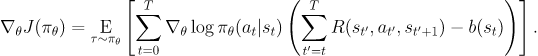

### Baseline Proof

**Question**: Prove that adding a baseline doesn't change the policy in expectation using the EGLP lemma.  This can be a loose proof as long as you convey the intutition. (10 pts)

**Proof**: $\sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t| x_t)(\sum_{t'=t}^{T}R(s_{t'}, a_{t'}, s_{t'+1}))$ is equivalent to adding and subtracting the baseline, yielding $\sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t| x_t)(\sum_{t'=t}^{T}R(s_{t'}, a_{t'}, s_{t'+1}) - b(s_t) + b(s_t))$

This is equal to $\sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t| x_t)(\sum_{t'=t}^{T}R(s_{t'}, a_{t'}, s_{t'+1}) - b(s_t))$ plus a term that is a constant with respect to $\theta$ (since $b(s_t)$ does not depend on $\theta$) multiplied by $\sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t| x_t)$. When we take the expectation, this latter term collapses to 0 by the EGLP lemma as the constant with respect to theta comes out of the expectation and we can apply the lemma.

Empirically, using the on-policy value function as the baseline ($b$) reduces variance in the policy gradient sample estimate, leading to faster and more stable learning.  We can estimate the $b$ using an L2 loss to the true rewards (or in our case, the discounted rewards), and constitutes an additional loss term in the overall objective. The baseline substracted return term, $R(s_{t'},a_{t'},s_{t' + 1}) - b(s_t)$ is already computed for you, and is referred to as the *advantage*.

In [ ]:
def compute_policy_loss_with_baseline(logps, advantages):
    policy_loss = 0

    ### TODO: implement the policy loss (5 pts) ######
    policy_loss = - torch.mean(logps * advantages)
    ##################################################

    return policy_loss

#### Test discounted return ####
checker_policy_gradient.test_compute_policy_loss_with_baseline(compute_policy_loss_with_baseline)

In [ ]:
def update_parameters_with_baseline(optimizer, acmodel, sb, args):
    
    def _compute_value_loss(values, rewards):
        value_loss = 0

        ### TODO: implement the value loss (5 pts) #######
        value_loss = F.mse_loss(values, rewards)
        ##################################################

        return value_loss

    logps, advantage, values, reward = None, None, None, None

    ### TODO: populate the policy and value loss computation fields using acmodel, sb['obs'], sb['action], and sb['discounted_reward']
    ### For the advantage term, use sb['advantage_gae'] if args.use_gae is True, and sb['advantage'] otherwise.
    ### 10 pts

    dist, values, std_devs = acmodel(sb['obs'])
    # print("acmodel.critic_mask in update_parameters_with_baseline", acmodel.critic_mask)
    # print("preceding critic mask should be acmodel.critic_mask in update_parameters_with_baseline")
    logps = dist.log_prob(sb['action'])
    advantage = sb['advantage_gae_with_bonus'] if args.use_gae else sb['advantage_with_bonus']
    rewards = sb['discounted_reward']
    

    ####################################################################################################

    policy_loss = compute_policy_loss_with_baseline(logps, advantage)
    value_loss = _compute_value_loss(values, rewards)
    loss = policy_loss + value_loss

    update_policy_loss = policy_loss.item()
    update_value_loss = value_loss.item()

    # Update actor-critic
    optimizer.zero_grad()
    loss.backward()
    update_grad_norm = sum(p.grad.data.norm(2) ** 2 for p in acmodel.parameters()) ** 0.5

    # max_grad_norm gets multiplied by total number of models, which is actor (1) plus the number of critics
    torch.nn.utils.clip_grad_norm_(acmodel.parameters(), args.max_grad_norm)
    # print("update_grad_norm", update_grad_norm)
    optimizer.step()

    # Log some values

    logs = {
        "policy_loss": update_policy_loss,
        "value_loss": update_value_loss,
        "grad_norm": update_grad_norm
    }

    return logs

## Reinforce with GAE (param loop)

The advantage we computed above seemed to work, and hopefully improved our results!  Fortunately, we can do even better.  The paper [Generalized Advantage Estimation](https://arxiv.org/abs/1506.02438) describes a nifty method for building a strong advantage estimate (see formula 16 in the paper) that empirically outperforms a naive subtraction (and includes reward shaping).

Fill in the `compute_advantage_gae` method above according to the formula in the paper (10 pts), and then run the below cell.  GAE should further improve convergence time and stability.

In [38]:
##### ADDED CODE
def param_loop(folder_location="/content/gdrive/My Drive/Sensorimotor_Final/",
               file_information_path= "/content/gdrive/My Drive/Sensorimotor_Final/file_infos.pckl",
               exploration_betas=[0.1],
               nums_critics=[3],
               env_sizes=[5],
               seeds=[0],
               use_soft_target_update=False, 
               exploration_update_freq=[300],
               max_grad_norms = [.5],
               critic_mask_for_ep=False,):
  file_infos = []
  drive.mount('/content/gdrive')

  for seed in seeds:
    print("seed", seed)
    for exploration_beta in exploration_betas:
      print("exploration_beta", exploration_beta)
      for num_critics in nums_critics:
        print("num_critics", num_critics)
        for env_size in env_sizes:
          print("env_size", env_size)
          for exp_up in exploration_update_freq: 
            print("exp_up", exp_up)
            for mask_en in critic_mask_for_ep: 
              print("critic_mask_for_ep", mask_en)
              for max_grad_norm in max_grad_norms: 
                print("max_grad_norm", max_grad_norm)
                args = Config(use_gae=True, 
                              num_critics=num_critics, 
                              seed=seed, 
                              exploration_beta=exploration_beta, 
                              env_size=env_size, 
                              use_soft_target_update=use_soft_target_update, 
                              exploration_update_freq=exp_up, 
                              critic_mask_for_ep=mask_en,
                              max_grad_norm=max_grad_norm)

                logs = run_experiment(args=args, parameter_update=update_parameters_with_baseline, seed=seed)

                file_name = folder_location + "_beta-" + str(exploration_beta) + "_critic-" + str(num_critics) + "_env-" + str(env_size) + "_seed-" + str(seed) + "_soft-" + str(use_soft_target_update) + "exp_up" + str(exp_up)+ "mask_en"+str(mask_en)+".pckl"
                f = open(file_name, "wb")
                pickle.dump(logs, f)
                f.close()

                file_info = {"exploration_beta": exploration_beta,
                            "num_critics": num_critics,
                            "env_size": env_size,
                            "seed": seed,
                            "use_soft_target_update": use_soft_target_update,
                            "file_name": file_name,
                            "exploration_update_freq": exp_up,
                            }
                file_infos.append(file_info)
        
                # do this every time in case something dies mid run
                f = open(file_information_path, "wb")
                pickle.dump(file_infos, f)
                f.close()

In [ ]:
def read_files(file_infos_path):
  f = open(file_infos_path, "rb")
  file_infos = pickle.load(f)
  f.close()

  for file_info in file_infos:
    file_name = file_info["file_name"]

    f = open(file_name, "rb")
    data = pickle.load(f)
    f.close

    file_info["data"] = data

  return file_infos

  file_infos = read_files(file_infos_path)

In [ ]:
# file_infos = read_files("/content/gdrive/My Drive/Sensorimotor_Final/file_infos.pckl")
# file_infos[0]["data"].plot(x='num_frames', y=['reward', 'smooth_reward'])

In [39]:
param_loop(folder_location="/content/gdrive/My Drive/Sensorimotor_Final/mask_per_ep_testing/",
               file_information_path= "/content/gdrive/My Drive/Sensorimotor_Final/mask_per_ep_testing/file_infos_grad_norm_clipping_.5_exp_300_steps_bigbeta.pckl",
               exploration_betas=[0.01],
               nums_critics=[5],
               env_sizes=[5],
               seeds=[24, 36, 38],
               use_soft_target_update=False,
               exploration_update_freq=[300], 
               max_grad_norms = [.8, 10],
               critic_mask_for_ep = [False])

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
seed 24
exploration_beta 0.01
num_critics 5
env_size 5
exp_up 300
critic_mask_for_ep False
max_grad_norm 0.8


  0%|          | 0/2000 [00:00<?, ?it/s]

Solved!
max_grad_norm 10


  0%|          | 0/2000 [00:00<?, ?it/s]

Solved!
seed 36
exploration_beta 0.01
num_critics 5
env_size 5
exp_up 300
critic_mask_for_ep False
max_grad_norm 0.8


  0%|          | 0/2000 [00:00<?, ?it/s]

Solved!
max_grad_norm 10


  0%|          | 0/2000 [00:00<?, ?it/s]

Solved!
seed 38
exploration_beta 0.01
num_critics 5
env_size 5
exp_up 300
critic_mask_for_ep False
max_grad_norm 0.8


  0%|          | 0/2000 [00:00<?, ?it/s]

Solved!
max_grad_norm 10


  0%|          | 0/2000 [00:00<?, ?it/s]

Solved!


In [ ]:
# set exploration_beta to 0 and num_critics to 1 for regular GAE
args = Config(num_critics=3, use_gae=True, exploration_beta=0.1)
df_gae = run_experiment(args, update_parameters_with_baseline)

df_gae.plot(x='num_frames', y=['reward', 'smooth_reward'])

In [ ]:
# realized that because of how i was passing in steps, soft update is too conservative
args = Config(num_critics=3, use_gae=True, exploration_beta=0.1, use_soft_target_update=True)
df_gae_soft_update = run_experiment(args, update_parameters_with_baseline)

df_gae_soft_update.plot(x='num_frames', y=['reward', 'smooth_reward'], title="with soft update target network")

In [ ]:
df_gae.plot(x='num_frames', y=['smooth_reward', 'value_loss', 'policy_loss'], title="with hard update target network")

In [ ]:
df_gae.plot(x='num_frames', y=['smooth_reward', 'value_loss', 'policy_loss'])

In [ ]:
df_gae

# Proximal Policy Optimization

Our work is not yet done!  There are some surprisingly powerful additional tweaks we can make to our GAE implementation to further improve performance.

The current standard in policy gradients today is [Proximal Policy Optimization](https://arxiv.org/abs/1707.06347), which improves on GAE by taking multiply policy update steps per minibatch, enabled by policy update clipping (this is a specific variant called *PPO-Clip*).  This leads to greater sample efficiency, as larger steps can be taken from the same data samples.

We've implemented most of PPO for you: all that's left for you are the policy and value loss computations (note that you'll have to evaluate the `acmodel` each time you compute them).  Note that for the policy loss, we also ask that you return the approximate KL divergence between the new and old action distributions notated as `approx_kl`; this is used to facilitate an early stopping condition in policy updates. This [blog post](http://joschu.net/blog/kl-approx.html) shares a simple formula for approximating KL divergence that you can use.

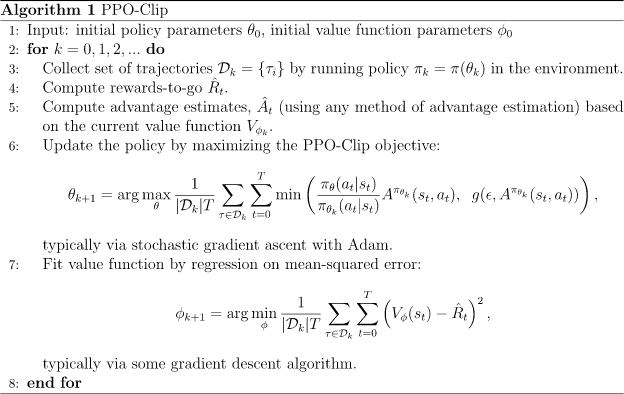

where 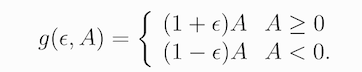

A commonly used technique is to add entropy regularization for policy gradient methods as shown in equation 2 of [this paper](https://arxiv.org/pdf/1611.01626.pdf), and there is some discussion of entropy regularization in this [reference tutorial](https://arxiv.org/pdf/1805.00909.pdf). You should compute the policy loss as defined above and also add in an entropy term for the updated policy (note that we've provided to you an entropy coefficient in `args.entropy_coef`).

In [ ]:
def update_parameters_ppo(optimizer, acmodel, sb, args):
    def _compute_policy_loss_ppo(obs, old_logp, actions, advantages):
        policy_loss, approx_kl = 0, 0

        ### TODO: implement PPO policy loss computation (30 pts).  #######

        ##################################################################
        
        return policy_loss, approx_kl
    
    def _compute_value_loss(obs, returns):
        ### TODO: implement PPO value loss computation (10 pts) ##########

        ##################################################################

        return value_loss


    dist, _ = acmodel(sb['obs'])            
    old_logp = dist.log_prob(sb['action']).detach()
    
    advantage = sb['advantage_gae'] if args.use_gae else sb['advantage']

    policy_loss, _ = _compute_policy_loss_ppo(sb['obs'], old_logp, sb['action'], advantage)
    value_loss = _compute_value_loss(sb['obs'], sb['discounted_reward'])

    for i in range(args.train_ac_iters):
        optimizer.zero_grad()
        loss_pi, approx_kl = _compute_policy_loss_ppo(sb['obs'], old_logp, sb['action'], advantage)
        loss_v = _compute_value_loss(sb['obs'], sb['discounted_reward'])

        loss = loss_v + loss_pi
        if approx_kl > 1.5 * args.target_kl:
            break
        
        loss.backward(retain_graph=True)
        optimizer.step()
    
    update_policy_loss = policy_loss.item()
    update_value_loss = value_loss.item()

    logs = {
        "policy_loss": update_policy_loss,
        "value_loss": update_value_loss,
    }

    return logs

In [ ]:
args = Config(num_critics=1, use_gae=True)
df_ppo = run_experiment(args, update_parameters_ppo)

df_ppo.plot(x='num_frames', y=['reward', 'smooth_reward'])

# Fancy Plots

If you've gotten to this point, congrats: you've succesfully implemented REINFORCE, VPG, GAE, and PPO!  While we've been able to anecdotally compare their performance, we don't have any sense of *scientific rigor*.  Notably, given the variance you've likely seen between runs of these models, a single run may not reflect how strong a model really is.

For this problem, train each of these 4 methods using multiple seeds (at least 5, but more if you feel you need them).  Then, generate a high quality reward curve plot comparing each algorithm.  The plot should be clean and legible, and clearly demonstrate the performance and variance of each of the approaches.  As an example, see Figure 3 of the PPO paper (although we're only evaluating on a single environment).

Be creative and make something pretty: it matters for good science!

**Note:** you should leave a few hours for this to run.

In [ ]:
seeds = [11, 42, 55, 80, 180]

args = Config(use_discounted_reward=True)
reinforce_dict = {}
for seed in seeds:
  df = run_experiment(args, update_parameters_reinforce, seed = seed)
  reinforce_dict[seed] = df

In [ ]:
seeds = [11, 42, 55, 80, 180]

args = Config(use_critic=True)
vpg_dict = {}
for seed in seeds:
  df = run_experiment(args, update_parameters_with_baseline, seed = seed)
  vpg_dict[seed] = df

In [ ]:
seeds = [11, 42, 55, 80, 180]

args = Config(use_critic=True, use_gae=True)
gae_dict = {}
for seed in seeds:
  df = run_experiment(args, update_parameters_with_baseline, seed = seed)
  gae_dict[seed] = df

In [ ]:
reinfoce_sr_df = pd.concat([reinforce_dict[key]['smooth_reward'] for key in reinforce_dict], axis=1)
reinforce_sr_mean = reinfoce_sr_df.ffill().mean(axis=1)
reinforce_sr_std = reinfoce_sr_df.std(axis=1)

vpg_sr_df = pd.concat([vpg_dict[key]['smooth_reward'] for key in vpg_dict], axis=1)
vpg_sr_mean = vpg_sr_df.ffill().mean(axis=1)
vpg_sr_std = vpg_sr_df.std(axis=1)

gae_sr_df = pd.concat([gae_dict[key]['smooth_reward'] for key in gae_dict], axis=1)
gae_sr_mean = gae_sr_df.ffill().mean(axis=1)
gae_sr_std = gae_sr_df.std(axis=1)


plt.plot(reinfoce_sr_df.index, reinforce_sr_mean, 'b-', label='Reinforce')
plt.fill_between(reinfoce_sr_df.index, reinforce_sr_mean - reinforce_sr_std, reinforce_sr_mean + reinforce_sr_std, color='b', alpha=0.2)

plt.plot(vpg_sr_df.index, vpg_sr_mean, 'r-', label='VPG')
plt.fill_between(vpg_sr_df.index, vpg_sr_mean - vpg_sr_std, vpg_sr_mean + vpg_sr_std, color='r', alpha=0.2)

plt.plot(gae_sr_df.index, gae_sr_mean, 'g-', label='GAE')
plt.fill_between(gae_sr_df.index, gae_sr_mean - gae_sr_std, gae_sr_mean + gae_sr_std, color='g', alpha=0.2)

plt.xlabel('Episode #')
plt.ylabel('Reward')
plt.title('Smoothed Reward Comparison')
plt.legend()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from google.colab import files

for key in reinforce_dict:
  df_to_save = reinforce_dict[key]
  df_to_save.to_csv(f'reinforce{key}.csv')
  files.download(f'reinforce{key}.csv')  

for key in gae_dict:
  df_to_save = gae_dict[key]
  df_to_save.to_csv(f'gae{key}.csv')
  files.download(f'gae{key}.csv')  

for key in gae_dict:
  df_to_save = gae_dict[key]
  df_to_save.to_csv(f'gae{key}.csv')
  files.download(f'gae{key}.csv')  

# Survey (bonus points, 10 pts)
Please fill out [this anonymous survey](https://forms.gle/khcLwWUPrtLziaFF7) and enter the code below to receive credit. Thanks!

**Code:**
variance_reduction